In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.initializers import he_normal
%matplotlib inline

# Display only top 5 and bottom 5 rows
pd.set_option('display.max_rows', 10)

Using TensorFlow backend.


In [2]:
# Set random seed for reproducibility
# Note: CuDNN is usually non-deterministic
# (can't determine which of the ~3000 threads finish earlier)
# And floating points reduction is not perfectly associative due to ULP rounding
import numpy as np
np.random.seed(1337)
import tensorflow as tf
tf.set_random_seed(1337)

In [3]:
df_train = pd.read_csv('./data/train_aWnotuB.csv', parse_dates=[0], infer_datetime_format=True)
df_train

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,20170630194
48116,2017-06-30 20:00:00,4,30,20170630204
48117,2017-06-30 21:00:00,4,16,20170630214
48118,2017-06-30 22:00:00,4,22,20170630224


# Preprocessing

In [4]:
train = df_train.pivot(index='DateTime',columns='Junction', values='Vehicles')
train

Junction,1,2,3,4
DateTime,,,,
2015-11-01 00:00:00,15.0,6.0,9.0,NaN
2015-11-01 01:00:00,13.0,6.0,7.0,NaN
2015-11-01 02:00:00,10.0,5.0,5.0,NaN
2015-11-01 03:00:00,7.0,6.0,1.0,NaN
2015-11-01 04:00:00,9.0,7.0,2.0,NaN
...,...,...,...,...
2017-06-30 19:00:00,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,90.0,31.0,28.0,16.0


## Remove Nan (0 vehicle)

In [5]:
train = train.fillna(0)

## Normalize the data on 0, 1

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [7]:
# scaler = MinMaxScaler(feature_range=(-1, 1))
# scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(0, 1))

In [8]:
train[train.columns] = scaler.fit_transform(train[train.columns])

In [9]:
train

Junction,1,2,3,4
DateTime,,,,
2015-11-01 00:00:00,0.066225,0.106383,0.044693,0.000000
2015-11-01 01:00:00,0.052980,0.106383,0.033520,0.000000
2015-11-01 02:00:00,0.033113,0.085106,0.022346,0.000000
2015-11-01 03:00:00,0.013245,0.106383,0.000000,0.000000
2015-11-01 04:00:00,0.026490,0.127660,0.005587,0.000000
...,...,...,...,...
2017-06-30 19:00:00,0.662252,0.702128,0.178771,0.305556
2017-06-30 20:00:00,0.602649,0.723404,0.167598,0.833333
2017-06-30 21:00:00,0.562914,0.638298,0.150838,0.444444


# Generate rolling forecast features

In [10]:
nb_forecast_per_junction = 24 * (31 + 31 + 30 + 31) # Days in jul + aug + sep + oct

In [11]:
nb_forecast_per_junction

2952

In [12]:
nb_forecast_per_junction * 4

11808

That will certainly not fit in the GPU VRAM --> We will get inspiration from seq2seq models and do a sliding window of time that matches a week.

In [39]:
num_feats = 4
seq_len = 24 * 7 # Sequence of 7 days (1 week)
num_outputs = 4
num_hidden = 20 # Keep 20 * 7 days of hidden states
bs = 1024
epochs = 50

We originally had 14592 rows, we will generate sequences of predictions from it.

In [40]:
def make_input_seqs(data, seq_len, train_split=0.9):
    seq_len = seq_len + 1
    result = []
    for index in range(len(data) - seq_len):
        result.append(data[index: index + seq_len, :])
    result = np.array(result) # shape (14423, 168, 4)
    train_ind = round(train_split * result.shape[0])
    train = result[:int(train_ind), :, :]
    x_train = train[:, :-1, :]
    y_train = train[:, -1, :]
    x_test = result[int(train_ind):, :-1, :]
    y_test = result[int(train_ind):, -1, :]

    return [x_train, y_train, x_test, y_test]

In [41]:
X_train, y_train, X_test, y_test = make_input_seqs(train.values, seq_len)

# Generate model

## Loss function

In [42]:
import keras.backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

## Neural net

In [43]:
from keras.optimizers import adam, rmsprop

In [44]:
# adam = adam(clipvalue=0.5) # Clip to avoid exploding gradients
rmsprop = rmsprop(clipvalue=0.5,
                  lr = 0.007)

In [45]:
from keras.layers import *
from keras.layers.core import *
from keras.layers.recurrent import *
from keras.models import *

In [46]:
def attention_n_days_ago(inputs, days_ago):
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = days_ago * 24
    
    # We compute the attention over the seq_len
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    
    # Now we convolute so that it average over the whole time window
    feats_depth = int(inputs.shape[2])
    avg = Lambda(lambda x: K.expand_dims(x, axis = 1))(inputs)
    avg = SeparableConv2D(feats_depth, (1,1))(avg)
    avg = Lambda(lambda x: K.squeeze(x, 1))(avg)
    
    
    a_probs = Permute((2, 1), name='attn_' + str(days_ago) + '_days')(avg)
    # out = multiply([inputs, a_probs], name='attn_mul_'+ str(days_ago) +'_days')
    out = Concatenate(name='attention_cat_'+ str(days_ago) +'_days')([inputs, a_probs])
    return out

In [47]:
def Net(num_feats, seq_len, num_hidden, num_outputs):
    x = Input((seq_len, num_feats))

    # Encoder RNNs
    enc = LSTM(seq_len,
               return_sequences=True)(x)
    
    # Attention decoders
    attention_1w = attention_n_days_ago(enc, 7)
    attention_1m = attention_n_days_ago(enc, 30)
    attention_1q = attention_n_days_ago(enc, 92)
    attention_1y = attention_n_days_ago(enc, 365)
    
    att = Concatenate(name='attns_cat')([attention_1w,
                                         attention_1m,
                                         attention_1q,
                                         attention_1y])
    
    # How to merge? concat, mul, add, let NN learn ?
    att = Permute((2, 1))(att)
    
    # Decoder RNN
    dec = LSTM(num_hidden,
               return_sequences=False)(att)

    # Regressor
    # Note that Dense is automatically TimeDistributed in Keras 2
    out = Dense(num_outputs)(dec)
    # out = Activation("linear")(out) # No-op
    
    model = Model(inputs=x, outputs=out)
                          
    model.compile(loss= root_mean_squared_error, optimizer= rmsprop)
    return model

In [48]:
model = Net(num_feats, seq_len, num_hidden, num_outputs)

In [49]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 168, 4)       0                                            
__________________________________________________________________________________________________
lstm_10 (LSTM)                  (None, 168, 168)     116256      input_6[0][0]                    
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 1, 168, 168)  0           lstm_10[0][0]                    
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 1, 168, 168)  0           lstm_10[0][0]                    
__________________________________________________________________________________________________
lambda_13 

### Callbacks

In [50]:
from keras.callbacks import History, ModelCheckpoint, CSVLogger, EarlyStopping
import time

In [51]:
history = History()
checkpointer = ModelCheckpoint(filepath="checkpoints/" + time.strftime("%Y-%m-%d_%H%M-")+"seq2seq-double-encoder.hdf5",
                               verbose=1, save_best_only=False)
csv_logger = CSVLogger("checkpoints/" + time.strftime("%Y-%m-%d_%H%M-")+'training.log')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto')

# Training

In [52]:
model.fit(X_train, y_train,
          batch_size=bs,
          epochs=epochs,
          validation_split=0.05,
          callbacks=[history,checkpointer,csv_logger,early_stop])

Train on 12331 samples, validate on 650 samples
Epoch 1/50

12288/12331 [============================>.] - ETA: 0s - loss: 0.1559Epoch 00001: saving model to checkpoints/2017-11-18_1728-seq2seq-double-encoder.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.1557 - val_loss: 0.1636
Epoch 2/50

12288/12331 [============================>.] - ETA: 0s - loss: 0.0847Epoch 00002: saving model to checkpoints/2017-11-18_1728-seq2seq-double-encoder.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0848 - val_loss: 0.1087
Epoch 3/50

12288/12331 [============================>.] - ETA: 0s - loss: 0.0836Epoch 00003: saving model to checkpoints/2017-11-18_1728-seq2seq-double-encoder.hdf5

12331/12331 [==============================] - ETA: 0s - loss: 0.0836 - val_loss: 0.1339
Epoch 4/50

12288/12331 [============================>.] - ETA: 0s - loss: 0.0797Epoch 00004: saving model to checkpoints/2017-11-18_1728-seq2seq-double-encoder.hdf5

12331/12331 [====

# Validation

## Validation by feeding truth values

In [53]:
def plot_preds(y_truth, y_pred):
    for junction in range(4):
        plt.figure
        plt.plot(y_truth[:,junction], color = 'green', label = 'Real traffic')
        plt.plot(y_pred[:,junction], color = 'red', label = 'Predicted traffic')
        plt.title('Traffic Forecasting at junction %i' % (junction+1))
        plt.xlabel('Number of hours from Start')
        plt.ylabel('Traffic')
        plt.legend()
        plt.show()

In [54]:
y_pred = model.predict(X_test)

In [55]:
y_pred.shape

(1442, 4)

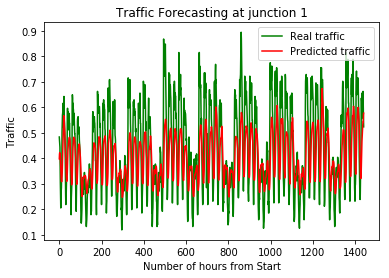

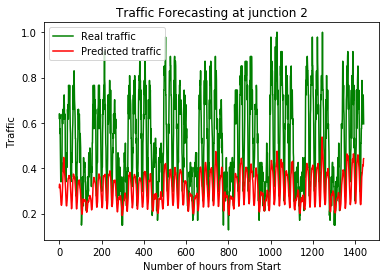

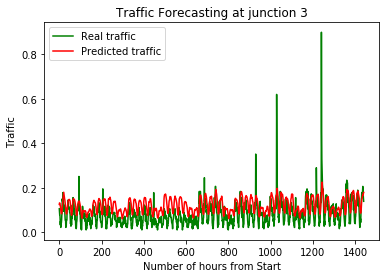

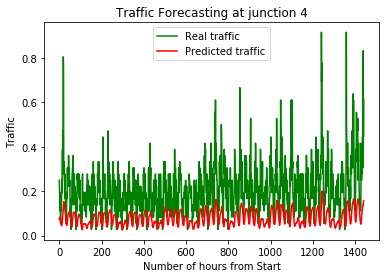

In [56]:
plot_preds(y_test, y_pred)

In [57]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [58]:
rmse(y_test, y_pred)

0.167121059771327

## Validation by feeding predicted values

In [59]:
def pred_seq(model, to_pred, w_size, num_preds=None):
    if num_preds == None:
        num_preds = to_pred.shape[0]
    current = to_pred[0]
    predicted = []
    for i in range(num_preds):
        predicted.append(model.predict(current[np.newaxis,:,:])[0,:])
        current = current[1:]
        current = np.insert(current, [w_size-1], predicted[-1], axis=0)
    return np.asarray(predicted)

In [60]:
seqpreds = pred_seq(model, X_test, seq_len)

In [61]:
seqpreds.shape

(1442, 4)

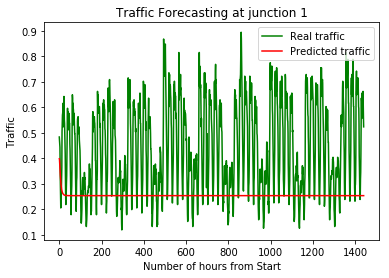

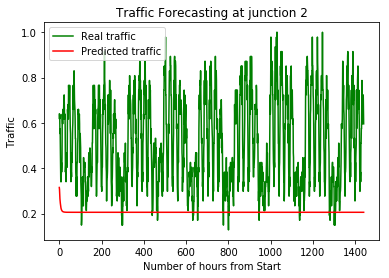

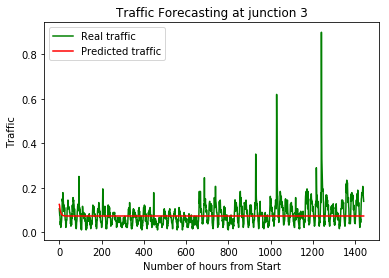

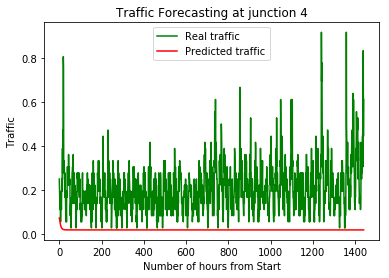

In [62]:
plot_preds(y_test, seqpreds)

In [63]:
rmse(y_test, seqpreds)

0.2506078852443461